In [1]:
import numpy as np
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import healpy as hp
import sys, platform, os
import correlator
import importlib
import pickle
import tqdm
from scipy import special

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
# camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
# sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower, correlations
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /Users/pecom/miniconda3/envs/astro/lib/python3.8/site-packages/camb


In [3]:
pspan = lambda mu, err : [mu-err, mu+err]

In [1132]:
def tls_to_model2(tl, t10):
    tl1, tl2 = tl
    h1 = (tl1/t10)**2
    h2 = (tl2/tl1)**2
    
#     print(h1, h2, h3)
    
    base_h1 = 7.4
    base_h2 = 0.51
    
    base_omegab = .02
    base_omegam = .35*(.65)**2
    
    delta_h1 = base_h1 - h1
    delta_h2 = base_h2 - h2
    
    rhs = np.array([delta_h1, delta_h2, 0])
    lhs = np.array([[.4, -.5], [-.64, .14], [-.31, .53]])
    (domegab, domegam), _, _, _ = np.linalg.lstsq(lhs, rhs, rcond=None)
    
    our_omegab = base_omegab*(1+domegab)
    our_omegam = base_omegam*(1+domegam)
    
    
    hrightfac = (.7/.65)**2
    noh_omegab = our_omegab*hrightfac
    noh_omegam = our_omegam*hrightfac
    
    return noh_omegab, noh_omegam

In [1151]:
def tls_to_model(tl, t10):
    tl1, tl2, tl3 = tl
    h1 = (tl1/t10)**2
    h2 = (tl2/tl1)**2
    h3 = (tl3/tl1)**2
    
#     print(h1, h2, h3)
    
    base_h1 = 7.4
    base_h2 = 0.51
    base_h3 = 0.50
    
    base_omegab = .02
    base_omegam = .35*(.65)**2
    
    delta_h1 = base_h1 - h1
    delta_h2 = base_h2 - h2
    delta_h3 = base_h3 - h3
    
    rhs = np.array([delta_h1, delta_h2, delta_h3])
    lhs = np.array([[.4, -.5], [-.64, .14], [-.31, .53]])
    (domegab, domegam), _, _, _ = np.linalg.lstsq(lhs, rhs, rcond=None)
    
    our_omegab = base_omegab*(1+domegab)
    our_omegam = base_omegam*(1+domegam)
    
    hrightfac = (.7/.65)**2
    
    noh_omegab = our_omegab*hrightfac
    noh_omegam = our_omegam*hrightfac
    
    return noh_omegab, noh_omegam

In [599]:
def alm_to_cl(alm):
    cl = []
    calc_ls = []
    for l, als in enumerate(alm):
        lval = 1/(2*l+1)*np.sum(np.abs(als)**2)
        cl.append(lval)
        calc_ls.append(l)
    return np.array(cl), np.array(calc_ls)

In [847]:
def badcl_to_good(ls, cl):
    above_dipo = (ls >= 2)
    newls = ls[above_dipo]
    newcls = cl[above_dipo]
    goodcls = np.sqrt(newcls*newls*(newls+1)/(2*np.pi))
    return goodcls, newls

In [1211]:
def bin_thedata(data, ls, dbins):
    lsndx = np.digitize(ls, dbins)
    meanedata = np.array([np.mean(data[lsndx==i]) for i in range(1,len(dbins)+1)])
    errordata = np.array([np.std(data[lsndx==i])/(np.sqrt(np.sum(lsndx==i))) for i in range(1,len(dbins)+1)])
    return meanedata, errordata

In [7]:
fullmap = fits.open('./data/COM_CMB_IQU-smica_2048_R3.00_hm1.fits')
idata = fullmap[1].data["I_STOKES"]

fullmap has temperature (I) and polarization (Q,U) data as well. We can use this in the future to make nicer looking graphs if we want

In [8]:
qdata = fullmap[1].data["Q_STOKES"]
udata = fullmap[1].data["U_STOKES"]

In [9]:
# Check headers if you want
# fullmap[1].header;

Plotting spherical functions is very easy using healpy (python port of healpix)

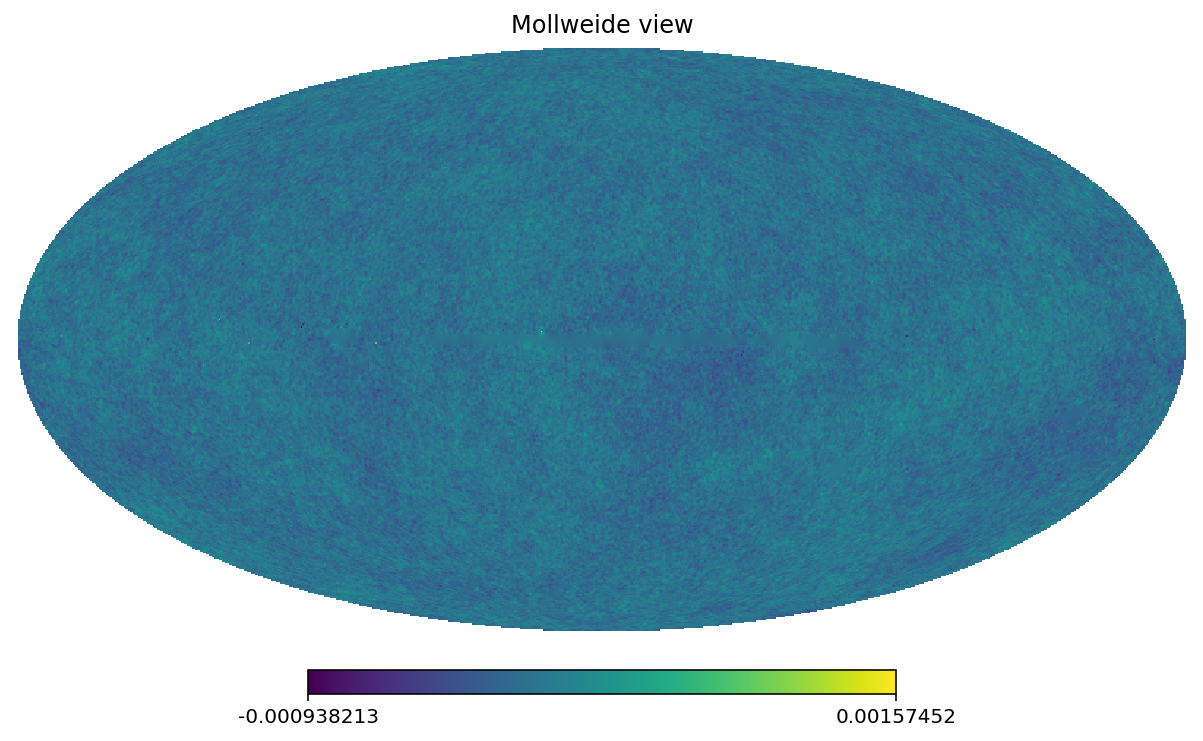

In [581]:
hp.mollview(idata, nest=True)

Data is given using "NESTED" ordering and we need it in "RING" (for anafast)

In [13]:
# Data is given using "NESTED" ordering
# we need it in RING to use anafast later on
ring_datai = hp.reorder(idata, inp='NESTED', out='RING')
ring_dataq = hp.reorder(qdata, inp='NESTED', out='RING')
ring_datau = hp.reorder(udata, inp='NESTED', out='RING')

There is a lot of data! For testing purposes, lower the quality down but we should not use this when actually doing analysis!

In [283]:
lesspretty = hp.ud_grade(ring_datai, 512)
lessQ = hp.ud_grade(ring_dataq, 512)
lessU = hp.ud_grade(ring_datau, 512)

Anafast does the power spectrum job!

In [1072]:
clfast = hp.anafast(lesspretty)
# clbest = np.load('./data/clbest.npy')

In [1075]:
# lbest = np.arange(len(clbest))
lfast = np.arange(len(clfast))

In [1076]:
bestcls, bestls = badcl_to_good(lbest, clbest)

In [1077]:
peak1 = [224, 20]
peak2 = [530, 20]
peak3 = [810, 30]
peaks = np.array([peak1, peak2, peak3])

In [1078]:
lsmax = bestls < 2500

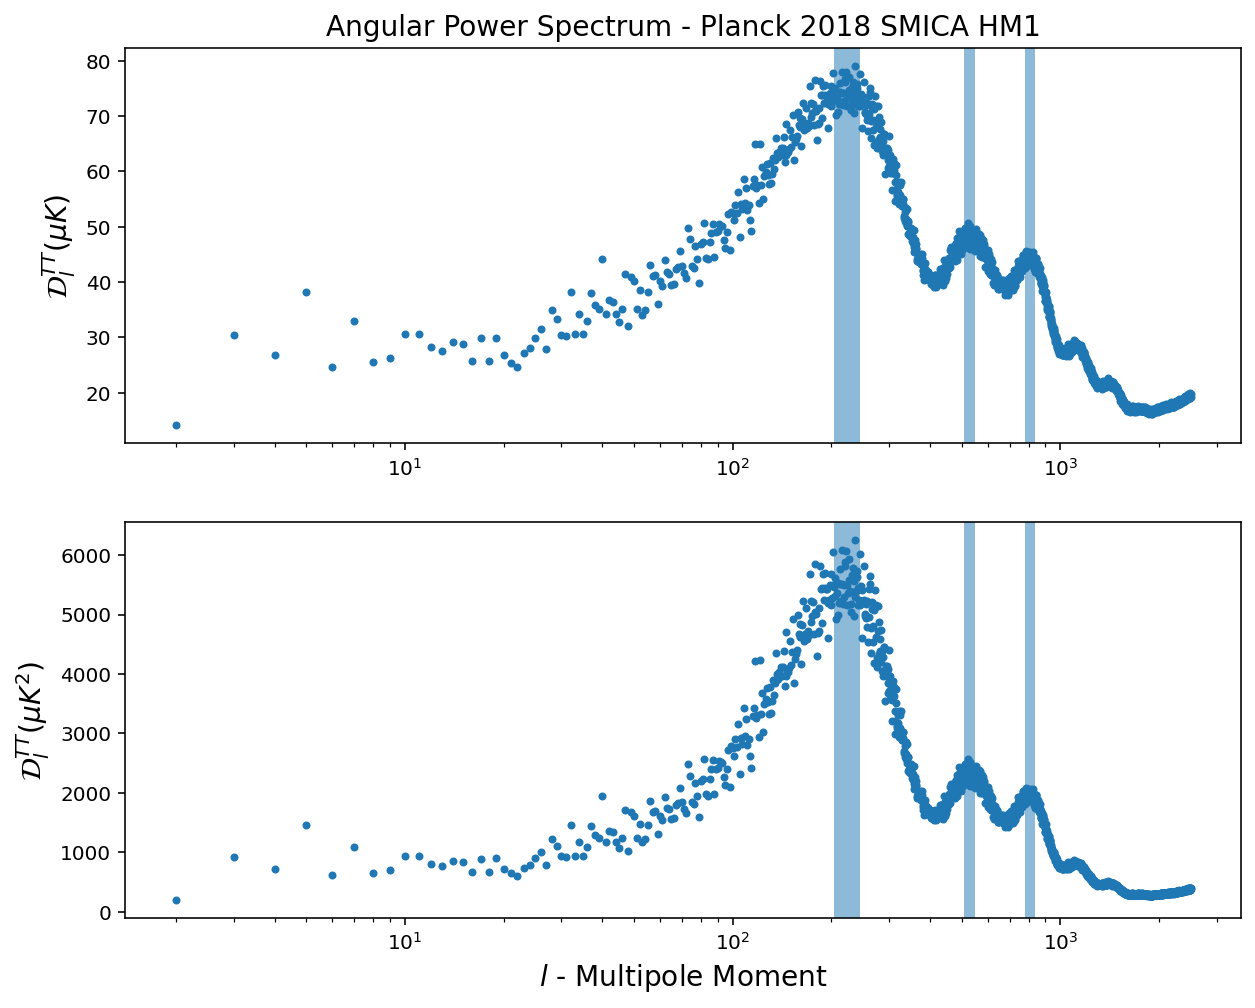

In [1079]:
fig, ax = plt.subplots(2, figsize=(10,8))

ax[0].plot(bestls[lsmax], (bestcls[lsmax]*1e6), '.')
ax[0].set_ylabel(r"$\mathcal{D}_l^{TT}(\mu K)$", fontsize=14)
# ax[0].set_xlabel(r"$l$ - Multipole Moment", fontsize=14)
ax[0].set_title("Angular Power Spectrum - Planck 2018 SMICA HM1", fontsize=14)

ax[1].plot(bestls[lsmax], (bestcls[lsmax]*1e6)**2, '.')
ax[1].set_ylabel(r"$\mathcal{D}_l^{TT}(\mu K^2)$", fontsize=14)
ax[1].set_xlabel(r"$l$ - Multipole Moment", fontsize=14)
# ax[1].set_title("Angular Power Spectrum - Planck 2018 SMICA HM1", fontsize=14)

ax[0].semilogx();
ax[1].semilogx();
for p in peaks:
    ax[0].axvspan(*pspan(*p), alpha=.5)
    ax[1].axvspan(*pspan(*p), alpha=.5)

# plt.savefig('../writeup/images/bestangspec.png', dpi=300, pad_inches = 0)

In [1080]:
fixedcls = bestcls

In [1081]:
t10_d = fixedcls[8]
t10 = np.mean(fixedcls[8:15])
t10_e = np.std(fixedcls[8:15])/np.sqrt(7)

In [1082]:
tls_d = fixedcls[peaks[:,0]]
tls = np.array([np.mean(fixedcls[pspan(*p)[0]:pspan(*p)[1]]) for p in peaks])
tls_err = np.array([np.std(fixedcls[pspan(*p)[0]:pspan(*p)[1]])/np.sqrt(p[1]*2) for p in peaks])

In [1156]:
max_samples = 5000
sample_omegab = np.zeros(max_samples)
sample_omegam = np.zeros(max_samples)

In [1142]:
# for i in range(max_samples):
#     new_sample = np.random.default_rng().normal(tls, tls_err, 3)
#     new_sample = new_sample[:-1]
# #     new_t10 = np.random.default_rng().normal(t10, t10_e)
#     new_t10 = t10
#     s_ob, s_om = tls_to_model2(new_sample, new_t10)
#     sample_omegab[i] = s_ob
#     sample_omegam[i] = s_om

In [1157]:
for i in range(max_samples):
    new_sample = np.random.default_rng().normal(tls, tls_err, 3)
#     new_t10 = np.random.default_rng().normal(t10, t10_e)
    new_t10 = t10
    s_ob, s_om = tls_to_model(new_sample, new_t10)
    sample_omegab[i] = s_ob
    sample_omegam[i] = s_om

In [1268]:
omegabmean = np.mean(sample_omegab)
omegammean = np.mean(sample_omegam)

In [1172]:
omegbstd = np.std(sample_omegab)/np.sqrt(max_samples)
omegmstd = np.std(sample_omegam)/np.sqrt(max_samples)

In [1269]:
(omegabmean - 0.02207)/(np.sqrt(omegbstd**2 + 0.00033**2))

-5.775392255596283

In [1276]:
1 - omegammean

0.9390682978185493

In [1270]:
(omegammean - 0.1423)/(np.sqrt(omegmstd**2 + 0.0029**2))

-28.02368726280703

In [1273]:
omegacmean = omegammean - omegabmean
omegacstd = np.sqrt(omegbstd**2 + omegmstd**2)

In [1275]:
print("Omega_b", omegabmean, omegbstd)
print("Omega_m",omegammean, omegmstd)
print("Omega_c",omegacmean, omegacstd)

Omega_b 0.02016408015972968 2.1485837992269378e-06
Omega_m 0.06093170218145076 0.00014362314295580968
Omega_c 0.04076762202172109 0.00014363921332577413


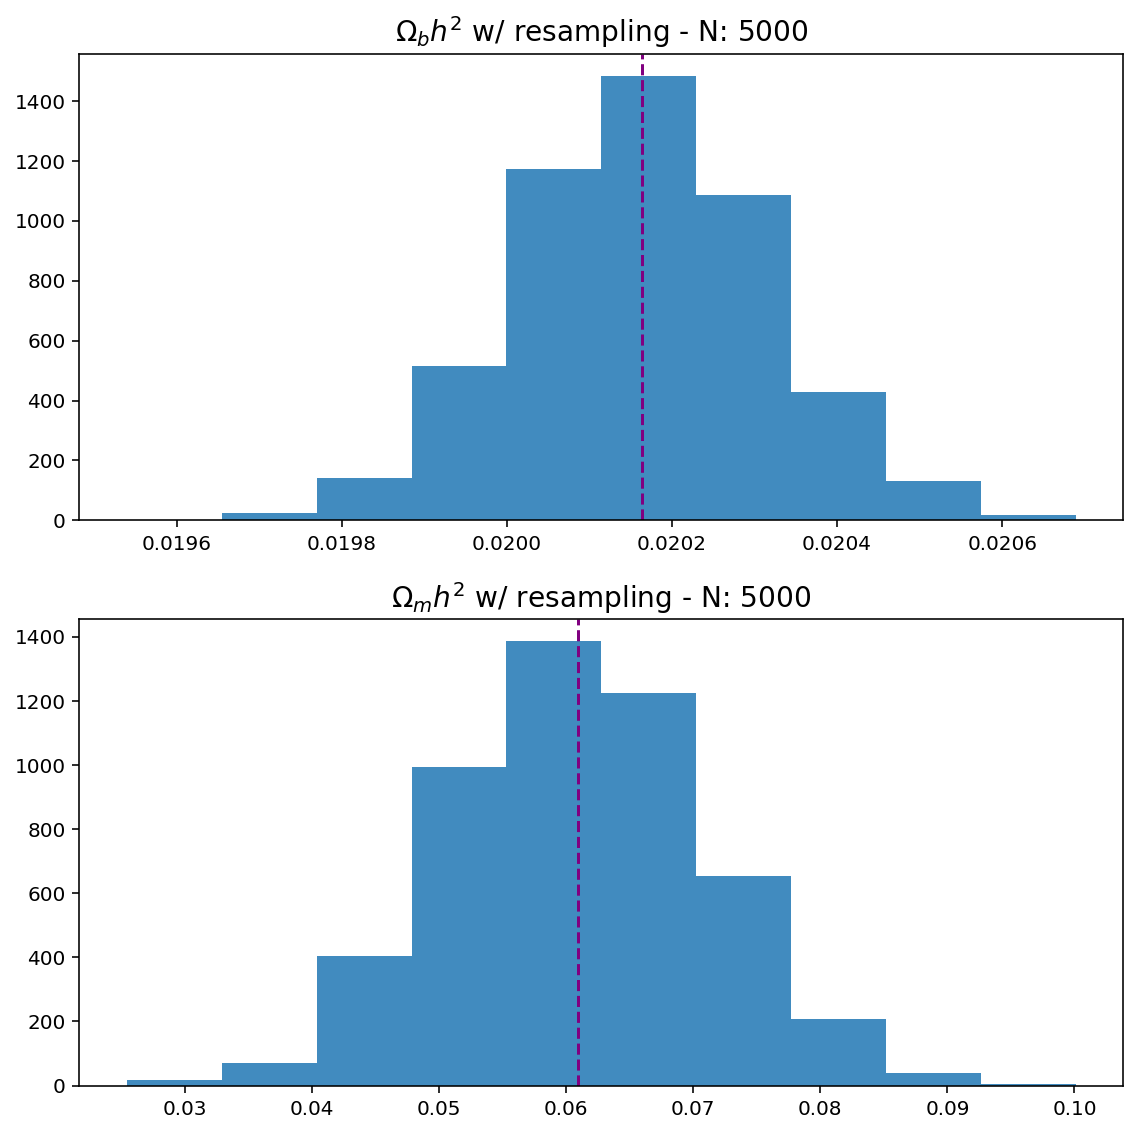

In [1160]:
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].hist(sample_omegab, alpha=.85)
ax[0].set_title(r"$\Omega_b h^2$ w/ resampling - N: " + str(max_samples), fontsize=14)
ax[0].axvline(np.mean(sample_omegab), color='purple', ls='--')

ax[1].hist(sample_omegam, alpha=.85)
ax[1].set_title(r"$\Omega_m h^2$ w/ resampling - N: " + str(max_samples), fontsize=14)
ax[1].axvline(np.mean(sample_omegam), color='purple', ls='--')

# plt.savefig('../writeup/images/resampled_params.png', dpi=300, pad_inches = 0)
plt.tight_layout();

In [23]:
print(np.mean(sample_omegam), np.std(sample_omegam))

0.08823515511688254 0.0169690773246349


In [24]:
cls_tqu = hp.anafast([lesspretty, lessQ, lessU])

In [810]:
tnside = 256

In [811]:
almostgarbage = hp.ud_grade(ring_datai, tnside)

/Users/pecom/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/pecom/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/pecom/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of 

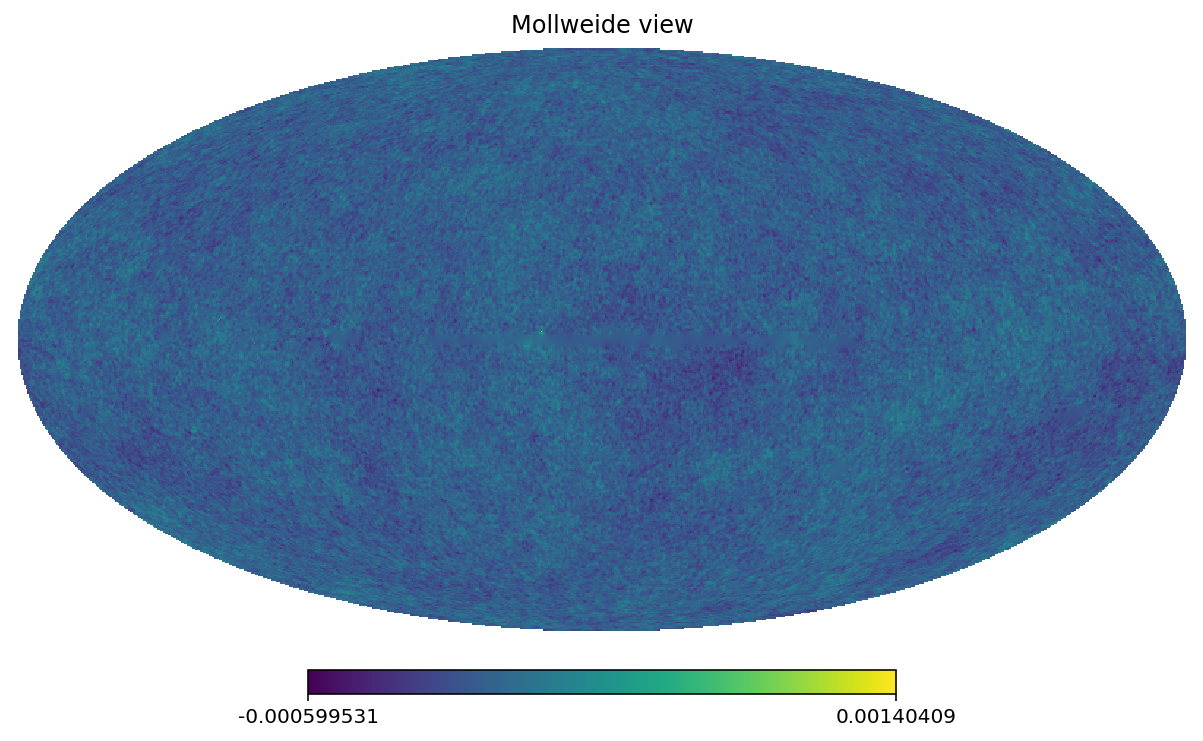

In [812]:
hp.mollview(almostgarbage);

In [727]:
angdict = {}
anglist = []
for i in range(hp.nside2npix(tnside)):
    angdict[i] = np.array(hp.pix2ang(tnside, i))
    anglist.append(np.array(hp.pix2ang(tnside, i)))
anglist = np.array(anglist)

In [728]:
lmax = 3*tnside - 1
print("lmax = ", lmax)

lmax =  191


In [804]:
A_lm = []
area = hp.nside2pixarea(256)
npix = hp.nside2npix(tnside)

In [715]:
# with fits.open('./data/healpix_full_weights_nside_0' + str(tnside) +'.fits') as f:
#     goodweights = f[1].data

In [716]:
# goodweights = fits.open('./data/healpix_full_weights_nside_0' + str(tnside) +'.fits')

In [717]:
A_lm = []
for l in range(lmax):
    lilm = []
    print(l)
    maxl = min(l, 10)
#     maxl=0
    for m in range(0, maxl+1):
        mval = np.sum(np.conj(special.sph_harm(m, l, anglist[:,1], anglist[:,0]))*almostgarbage*4*np.pi/npix)
        lilm.append(mval)
    A_lm.append(lilm)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [326]:
qualified_charlatan = hp.map2alm(almostgarbage, lmax=30)

In [761]:
lmax

191

In [777]:
lp, _ = special.lpmn(lmax, lmax, .2)

In [773]:
lp.shape

(192, 192)

In [751]:
special.lpmv(80, 100, .2)

2.707222716501562e+154

In [327]:
l = 12
m = 4

In [404]:
np.sum(np.conj(special.sph_harm(80, 100, anglist[:,1], anglist[:,0]))*almostgarbage*4*np.pi/npix)€

(-2.947642627290579e-07-8.067453240213771e-07j)

In [703]:
special.sph_harm(10, 800, anglist[:,1], anglist[:,0])

array([ 7.78071710e-16+2.54137507j, -6.84860411e-15-2.54137507j,
       -6.24030430e-16+2.54137507j, ..., -6.84860411e-15-2.54137507j,
       -6.24030430e-16+2.54137507j, -9.96089095e-15-2.54137507j])

In [431]:
np.conj(special.sph_harm(80, 200, np.linspace(0, np.pi, npix), anglist[:,0]))

array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j])

In [412]:
np.save('./data/angls', anglist)

In [389]:
talm[100][90]

(nan+nanj)

In [329]:
print(qualified_charlatan[hp.sphtfunc.Alm.getidx(30, l, m)])
print(A_lm[l][m])

(-6.085521486899863e-06+8.641178226662897e-07j)
(-6.085591358497927e-06+8.643563582079809e-07j)


In [805]:
def alm_to_cl(alm, tns):
    cl = []
    area = hp.nside2pixarea(tns)
    calc_ls = []
    for l, als in enumerate(alm):
        clean_als = np.array(als)[~np.isnan(als)]
        lval = np.sum((np.abs(clean_als))**2)*1/(len(clean_als))
        cl.append(lval)
        calc_ls.append(l)
    return np.array(cl), np.array(calc_ls)

In [1278]:
with open('./data/calc_alms_256_bad', 'rb') as f:
    talm = pickle.load(f)
tcl, tls = alm_to_cl(talm, tnside)

In [1215]:
# tcl, tls = alm_to_cl(A_lm, tnside)

In [1279]:
nicecls, nicels = badcl_to_good(tls, tcl)

In [1280]:
clfast = hp.anafast(almostgarbage)
lfast = np.arange(len(clfast))
fixedcls, ls = badcl_to_good(lfast, clfast)
fixedcls = fixedcls[:-1]
ls = ls[:-1]

In [1281]:
digbins = np.linspace(0, len(ls), 60)
# digbins = np.logspace(np.log10(np.min(ls)), np.log10(len(ls)), 30)

In [1282]:
meanednice, errnice = bin_thedata(nicecls, ls, digbins)
meanedbest, errbest = bin_thedata(fixedcls, ls, digbins)

In [1283]:
cmap = matplotlib.cm.get_cmap("tab10").copy()

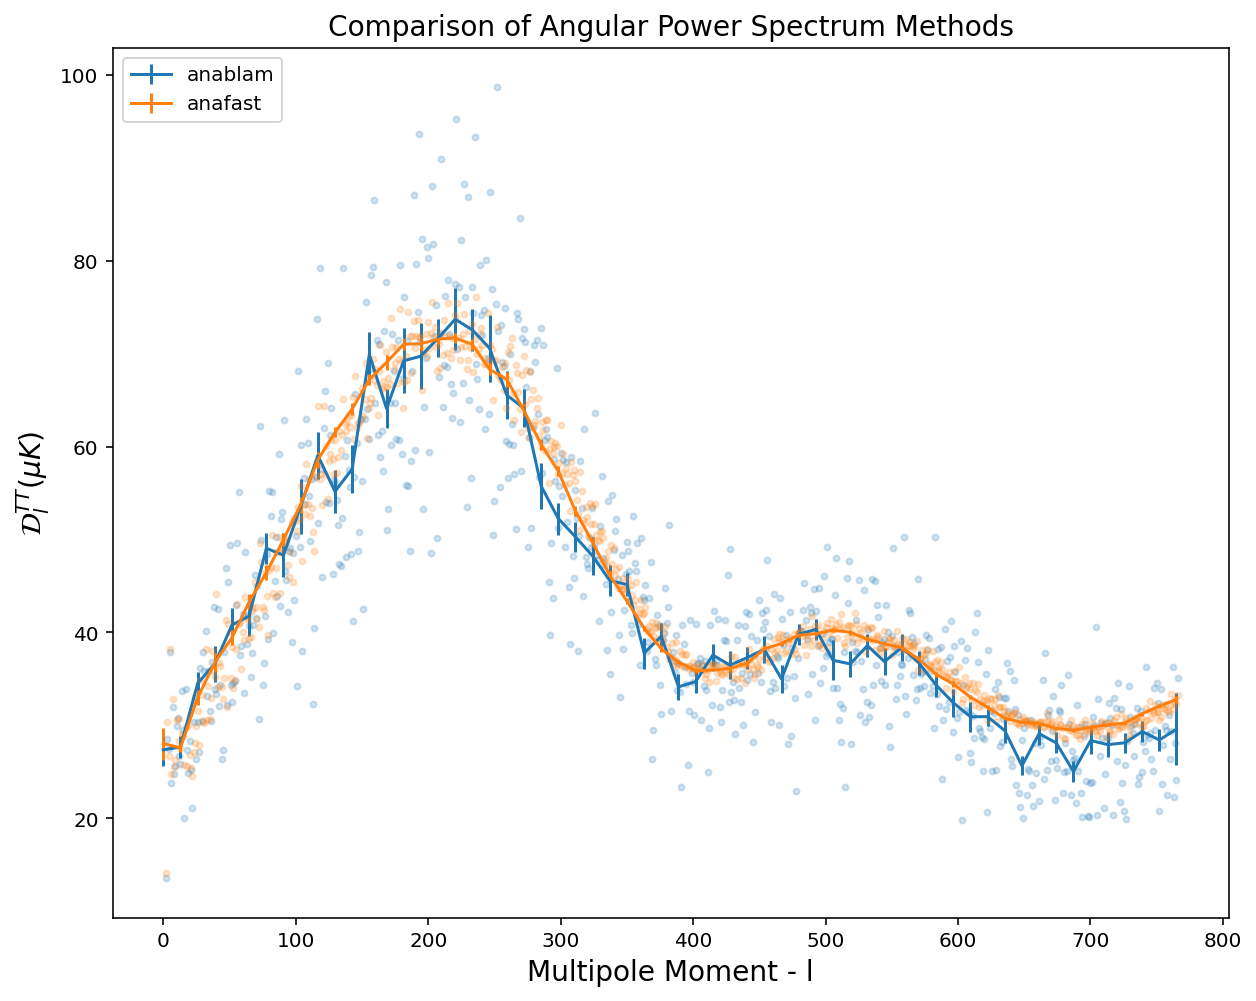

In [1285]:
fig, ax = plt.subplots(1, figsize=(10,8))

anablamcolor=0
anafastcolor=.1

ax.plot(nicels, nicecls*1e6, '.', alpha=.2, color=cmap(anablamcolor))
ax.plot(ls, fixedcls*1e6, '.', alpha=.2, color=cmap(anafastcolor))
ax.set_xlabel("Multipole Moment - l", fontsize=14)
ax.set_ylabel(r"$\mathcal{D}_l^{TT}(\mu K)$", fontsize=14)
ax.set_title("Comparison of Angular Power Spectrum Methods", fontsize=14)

ax.errorbar(digbins, meanednice*1e6, fmt='-', yerr=errnice*1e6, label=r"anablam", color=cmap(anablamcolor))
ax.errorbar(digbins, meanedbest*1e6, fmt='-', yerr=errbest*1e6, label=r"anafast", color=cmap(anafastcolor))

ax.legend(loc='upper left');
plt.savefig('../writeup/images/anablam.png', dpi=300, pad_inches = 0)

In [ ]:
"ANAfast - But Less Accurate Method" = ANABLAM

In [1184]:
best64 = hp.ud_grade(ring_datai, 64)

In [1203]:
cl64best = hp.anafast(best64)
l64fast = np.arange(len(cl64best))
fixedcls64, lsana = badcl_to_good(l64fast, cl64best)
fixedcls64 = fixedcls64[:-1]
lsana = lsana[:-1]

In [1185]:
cl64s = []

In [1186]:
with open('./data/calc_alms_64_bad_1_maxm', 'rb') as f:
    approx1 = pickle.load(f)
cl1, ls64 = alm_to_cl(approx1, 64)
cl64s.append(cl1)

In [1187]:
with open('./data/calc_alms_64_bad_10_maxm', 'rb') as f:
    approx10 = pickle.load(f)
cl1, _ = alm_to_cl(approx10, 64)
cl64s.append(cl1)

In [1188]:
with open('./data/calc_alms_64_bad_20_maxm', 'rb') as f:
    approx20 = pickle.load(f)
cl1, _ = alm_to_cl(approx20, 64)
cl64s.append(cl1)

In [1189]:
with open('./data/calc_alms_64_bad_40_maxm', 'rb') as f:
    approx40 = pickle.load(f)
cl1, _ = alm_to_cl(approx40, 64)
cl64s.append(cl1)

In [1198]:
better64cls = []
for c in cl64s:
    bet64, betls = badcl_to_good(ls64, c)
    better64cls.append(bet64)

In [1229]:
digbins = np.linspace(0, len(betls), 30)
# digbins = np.logspace(np.log10(np.min(ls)), np.log10(len(ls)), 30)

In [1230]:
binned_data = []
binned_errs = []
for b in better64cls:
    bd, be = bin_thedata(b, betls, digbins)
    binned_data.append(bd)
    binned_errs.append(be)

In [1241]:
cmap = matplotlib.cm.get_cmap("tab10").copy()

In [1246]:
bb, bb_err = bin_thedata(fixedcls64, betls, digbins)

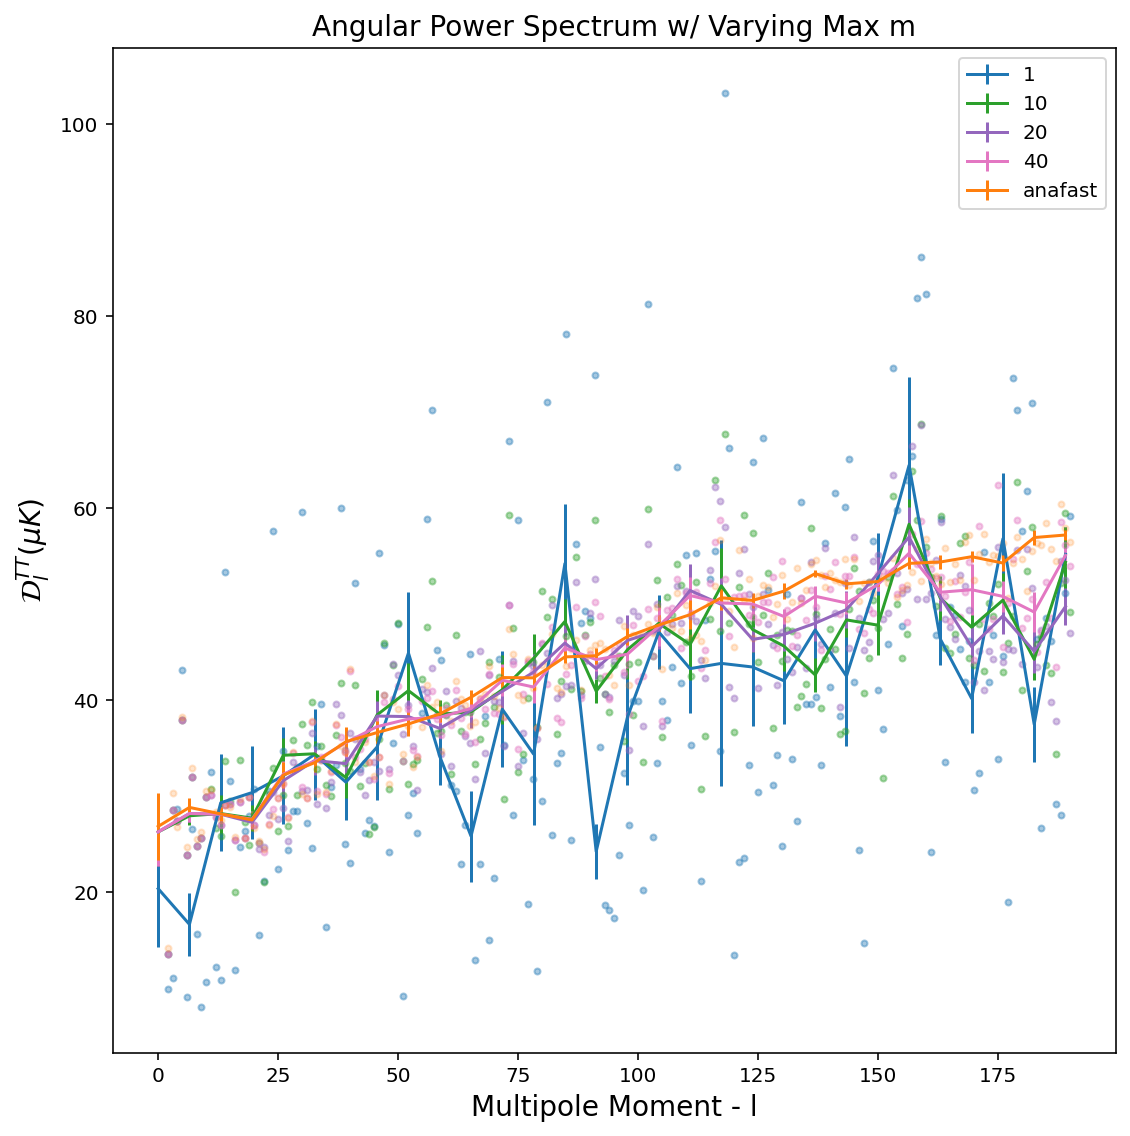

In [1267]:
fig, ax = plt.subplots(1, figsize=(8,8))

labels64 = [1,10, 20, 40]

for i,b in enumerate(better64cls):
    ax.plot(betls, b*1e6, '.', alpha=.4, color=cmap(i/5))

for i,b in enumerate(binned_data):
    ax.errorbar(digbins, b*1e6, fmt='-', yerr=binned_errs[i]*1e6, label=labels64[i], color=cmap(i/5))

ax.plot(lsana, fixedcls64*1e6, '.', alpha=.2, color=cmap(1))
ax.errorbar(digbins, bb*1e6, fmt='-', yerr=bb_err*1e6, label='anafast', color=cmap(1))

ax.set_title("Angular Power Spectrum w/ Varying Max m", fontsize=14)
ax.set_xlabel("Multipole Moment - l", fontsize=14)
ax.set_ylabel(r"$\mathcal{D}_l^{TT}(\mu K)$", fontsize=14)

ax.legend();
plt.tight_layout()
# plt.savefig('../writeup/images/varymanablam.png', dpi=300, pad_inches = 0)

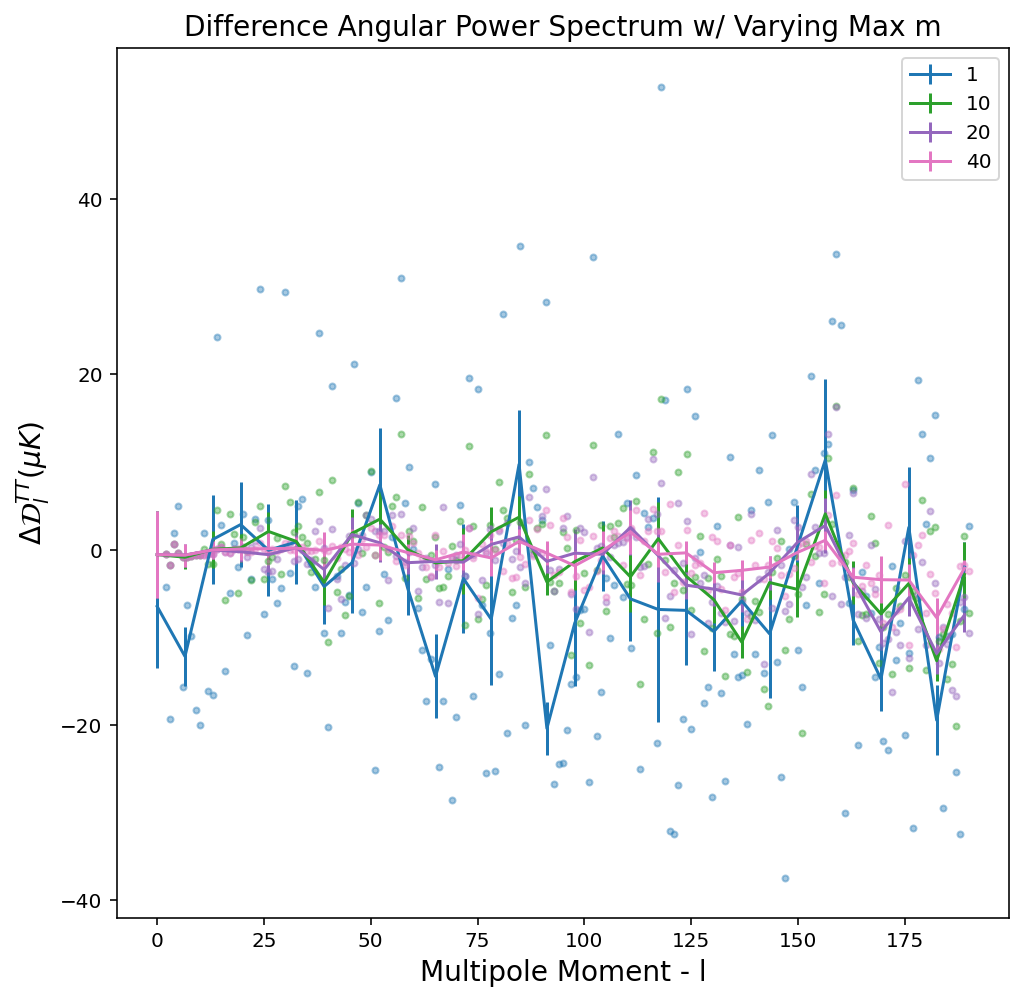

In [1265]:
fig, ax = plt.subplots(1, figsize=(8,8))

labels64 = [1,10, 20, 40]

diff_errs = [np.sqrt(binned_errs[i]**2 + bb_err**2) for i in range(4)]

for i,b in enumerate(better64cls):
    ax.plot(betls, b*1e6 - fixedcls64*1e6, '.', alpha=.4, color=cmap(i/5))

for i,b in enumerate(binned_data):
    ax.errorbar(digbins, b*1e6 - bb*1e6, fmt='-', yerr=diff_errs[i]*1e6, label=labels64[i], color=cmap(i/5))

# ax.plot(lsana, fixedcls64*1e6, '.', alpha=.2, color=cmap(1))
# ax.errorbar(digbins, bb*1e6, fmt='-', yerr=bb_err*1e6, label='anafast', color=cmap(1))

ax.set_title(r"Difference Angular Power Spectrum w/ Varying Max m", fontsize=14)
ax.set_xlabel("Multipole Moment - l", fontsize=14)
ax.set_ylabel(r"$\Delta\mathcal{D}_l^{TT}(\mu K)$", fontsize=14)

ax.legend();